In [1]:
# Math imports
import math
import numpy as np
import numba as nb
from sympy import *

# Combinatorics and data imports
import itertools
import data.DataGenerator as dg

# Auxiliary/visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('figstyle.mplstyle')

# Let's initialize a 2D dynamical system governed by an Anosov diffeomorphism using DataGenerator.
n = 2              # System dimensionality
X0 = [0.1, 0.3]    # Arbitrary initial conditions with coordinates \in [0,1)
NUM_STEPS = 1001   # Number of iterations to evolve system state

generator = dg.DataGenerator(X0, num_steps = NUM_STEPS, mapname = "anosov_diffeo", map_args = None) # Take default transition matrix A
X = generator.generate_series().T # Generate time series data; (2, NUM_STEPS) array

Xk = X[:,:-1] # State data at timestep k
Xkplus1 = X[:,1:] # Evolved state data at timestep k+1 ( == F(Xk) )

Text(0.5, 1.0, '2D trajectory of Anosov map')

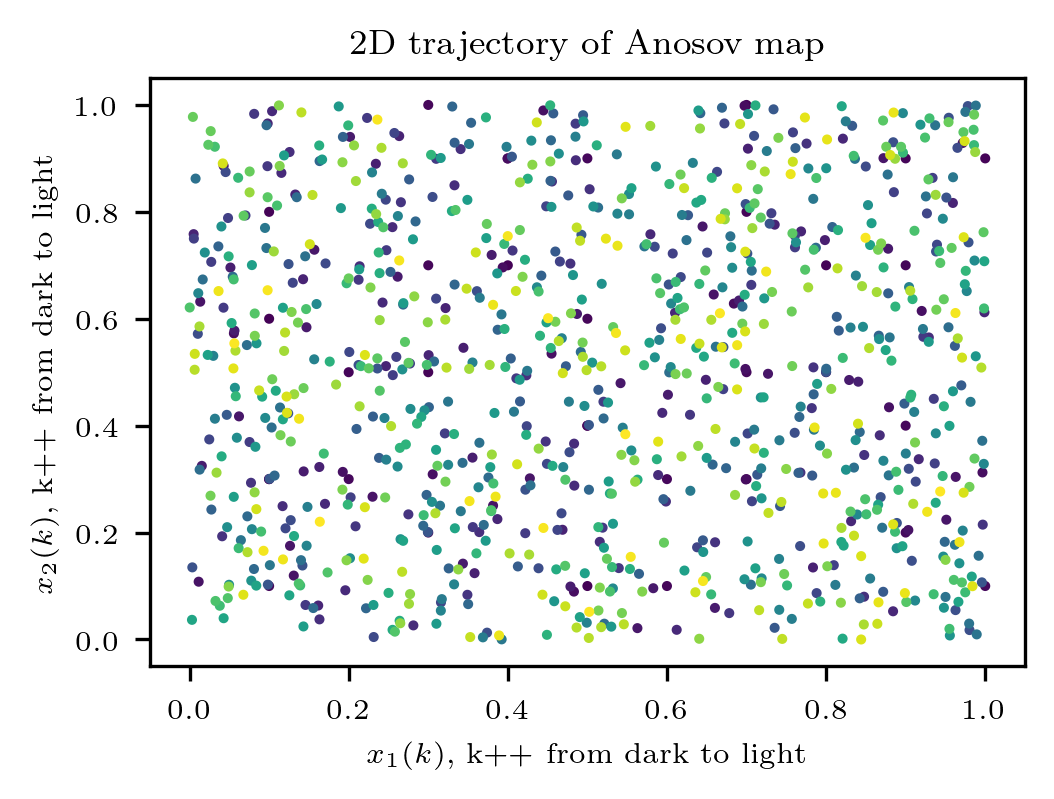

In [55]:
# Let's visualize this trajectory for the sake of example

cm = plt.get_cmap('viridis')
colors = [cm(i/NUM_STEPS) for i in range(NUM_STEPS)]

fig, ax = plt.subplots()
ax.scatter(X[0,:], X[1,:], s=2, c=colors)
ax.set(xlabel=r'$x_1(k)$, k++ from dark to light', ylabel=r'$x_2(k)$, k++ from dark to light')
ax.set_title("2D trajectory of Anosov map")

In [3]:
# Set up dictionary of basis functions
# For now, we will use polynomials up to order max_deg = 3
# I chose to avoid use of numpy.polynomial.hermite and/or hermite_e for downstream flexibility of basis function composition

# Number of dictionary entries
# is equivalent to len(basis_fns) if we are constructing basis functions via monomial combinatorics as below
def getDimPsi(n, max_deg):
    dim_Psi = 1
    for i in range(1, max_deg + 1):
        dim_Psi += math.factorial(n + i - 1) / (math.factorial(i) * math.factorial(n - 1))

    return int(dim_Psi)

# Create library of monomial basis functions up to order max_deg = 3
# Uses sympy for interpretability, convert to Numpy function using sympy.lambdify() at runtime
def createBasis(n, max_deg):
    
    symstring = ''
    for i in range(n):
        symstring += f'x{i+1} '
    symstring = symstring[:-1] # remove trailing whitespace
    pv = symbols(symstring) # define list of symbols as x1, x2, ... xn (dimensionality n).

    # Generate list of dictionary keys, which are tuples representing the type and multiplicity of symbols (\in pv) in each monomial
    keys = [(1,)]
    for i in range(1, max_deg + 1):
        keys += list(itertools.combinations_with_replacement(pv, i))

    basis_fns = dict.fromkeys(keys, None)

    for key in keys:
        basis_fns[key] = Lambda(pv, math.prod(key))

    return basis_fns, getDimPsi(n, max_deg)

In [4]:
max_deg = 3

# Build dictionary function Psi(X) using the basis; i.e., evaluate all basis functions at Xk for each timestep k
def Psi(X):

    n = X.shape[0]
    m = X.shape[1]

    basis, dimPsi = createBasis(n, max_deg)

    PsiX = np.zeros((dimPsi, m), dtype = np.float64)
    for k in range(m):
        # For each timestep k, take all basis functions fn in basis and evaluate at unpacked n-dimensional state coords X[:,k]
        PsiX[:, k] = [fn(*X[:, k]) for key, fn in basis.items()]

    return PsiX

In [5]:
# Intermezzo: create and print stuff to make sure it works

polybasis = createBasis(n, max_deg=3)
dimPsi = getDimPsi(n, max_deg=3)

print(dimPsi)
print(polybasis)
print(Psi(X))

10
({(1,): Lambda((x1, x2), 1), (x1,): Lambda((x1, x2), x1), (x2,): Lambda((x1, x2), x2), (x1, x1): Lambda((x1, x2), x1**2), (x1, x2): Lambda((x1, x2), x1*x2), (x2, x2): Lambda((x1, x2), x2**2), (x1, x1, x1): Lambda((x1, x2), x1**3), (x1, x1, x2): Lambda((x1, x2), x1**2*x2), (x1, x2, x2): Lambda((x1, x2), x1*x2**2), (x2, x2, x2): Lambda((x1, x2), x2**3)}, 10)
[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.1        0.5        0.4        ... 0.94342797 0.16371003 0.54770211]
 [0.3        0.4        0.9        ... 0.27685408 0.22028206 0.38399209]
 ...
 [0.003      0.1        0.144      ... 0.24641573 0.00590377 0.11518903]
 [0.009      0.08       0.324      ... 0.07231204 0.0079439  0.08075863]
 [0.027      0.064      0.729      ... 0.02122036 0.01068901 0.0566196 ]]


<Axes: >

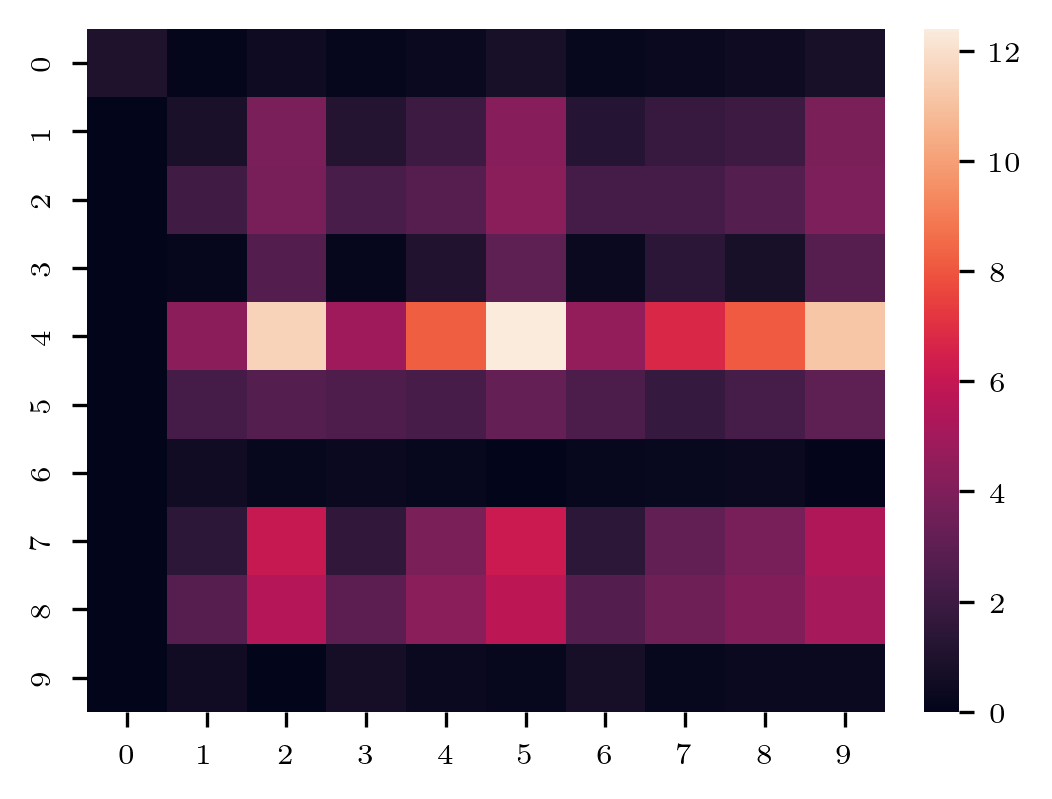

In [9]:
# Now, approximate the Koopman operator via EDMD.

# Lift the data
PsiX = Psi(Xk)
PsiY = Psi(Xkplus1)

# Compute K
# Use Moore-Penrose pseudo-inverse, instead of matrix inversion, for the general case
# A rcond threshold is set for numerical stability/interpretability according to Numerical Recipes, pg. 795. 2e-16 is machine error
# threshold for np.float64 dtype. 
K = np.linalg.pinv(PsiX @ PsiX.conj().T, rcond = n * 2e-16) @ PsiX @ PsiY.conj().T

# Projection operator
nPsi = getDimPsi(n, max_deg)
B = np.zeros((n, nPsi), dtype = np.float64)
# Should investigate why the following two lines are present in the Julia codebase
B[0, 2] = 1.0
B[1, 1] = 1.0

# Plot heatmap of absolute values of approximate Koopman operator K
sns.heatmap(np.abs(K))

Text(0.5, 1.0, '$Re(\\lambda)$ heatmap')

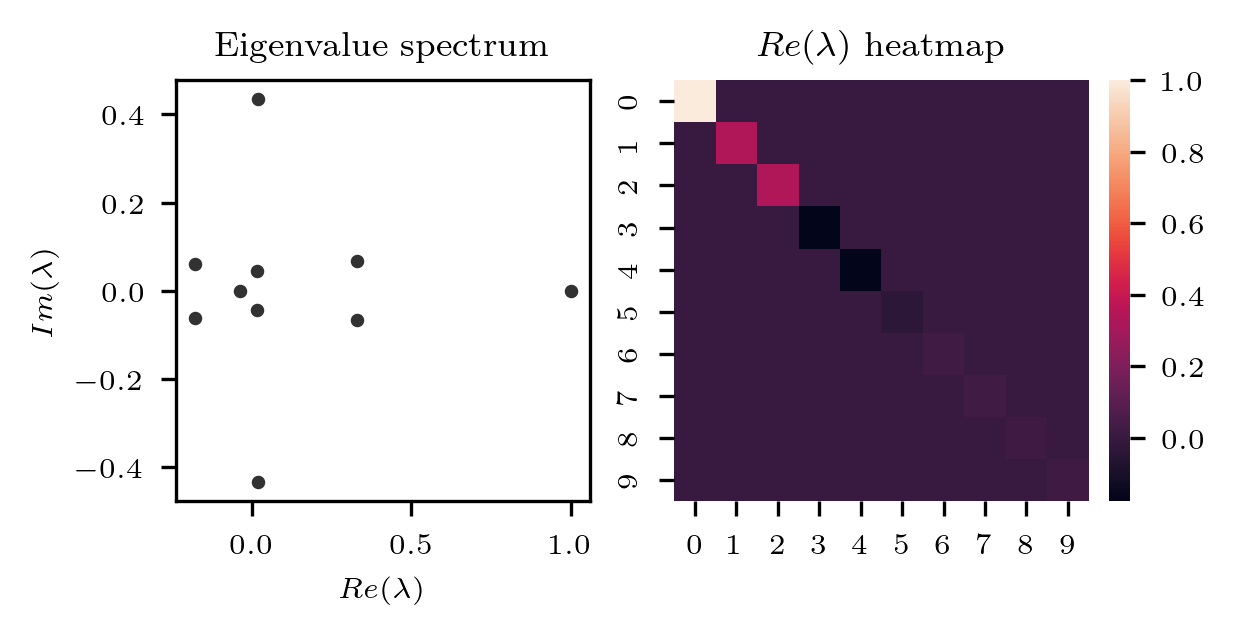

In [52]:
# Ignore warnings as discarding the complex component of eigenvals will raise a warning
import warnings
warnings.filterwarnings('ignore')

# Eigendecomposition of the Koopman operator
eigenvals, eigenvecs = np.linalg.eig(K)
eigenvals_real_component = np.abs(np.real(eigenvals))

# Some sorting, by the real component of the eigenvalues; descending order
eigenvals = np.array([x for _, x in sorted(zip(eigenvals_real_component, eigenvals), key = lambda pair: pair[0])], dtype = np.complex128)[::-1]
eigenvecs = np.array([x for _, x in sorted(zip(eigenvals_real_component, eigenvecs), key = lambda pair: pair[0])], dtype = np.complex128)[::-1]

# Visualize the eigenvalue spectrum
fig, ax = plt.subplots(1, 2, figsize=(4, 2))

ax[0].scatter(np.real(eigenvals), np.imag(eigenvals), s = 5)
ax[0].set(xlabel=r'$Re(\lambda)$', ylabel=r'$Im(\lambda)$')
ax[0].set_title("Eigenvalue spectrum")

sns.heatmap(np.diag(np.real(eigenvals)), ax=ax[1])
ax[1].set_title(r'$Re(\lambda)$ heatmap')


In [61]:
# Compute the Koopman eigenfunctions and evaluate on an equidistant grid

nsamples = 101
xgrid = np.linspace(-1, 1, nsamples)
xgrid2 = np.tile(xgrid[:, None], (1, nsamples))
xgrid1 = np.tile(xgrid, (nsamples, 1))

phi_max = 20

phi = np.zeros((nsamples, nsamples, min(nPsi, phi_max)))
xij = np.zeros((2, 1))
for k in range(min(nPsi, phi_max)):
    for i in range(nsamples):
        # I am pretty sure .conj().T on the xgridn[i, :] does nothing, so we can remove downstream
        phi[i, :, k] = np.real(eigenvecs[:, k].conj().T) @ Psi(np.vstack([xgrid1[i, :].conj().T, xgrid2[i, :].conj().T]))

def vecnorm(x, lb = 0.35):
    dx = np.max(x) - np.min(x)
    return ((((x - np.min(x)) / dx) + lb) / (1 + lb))

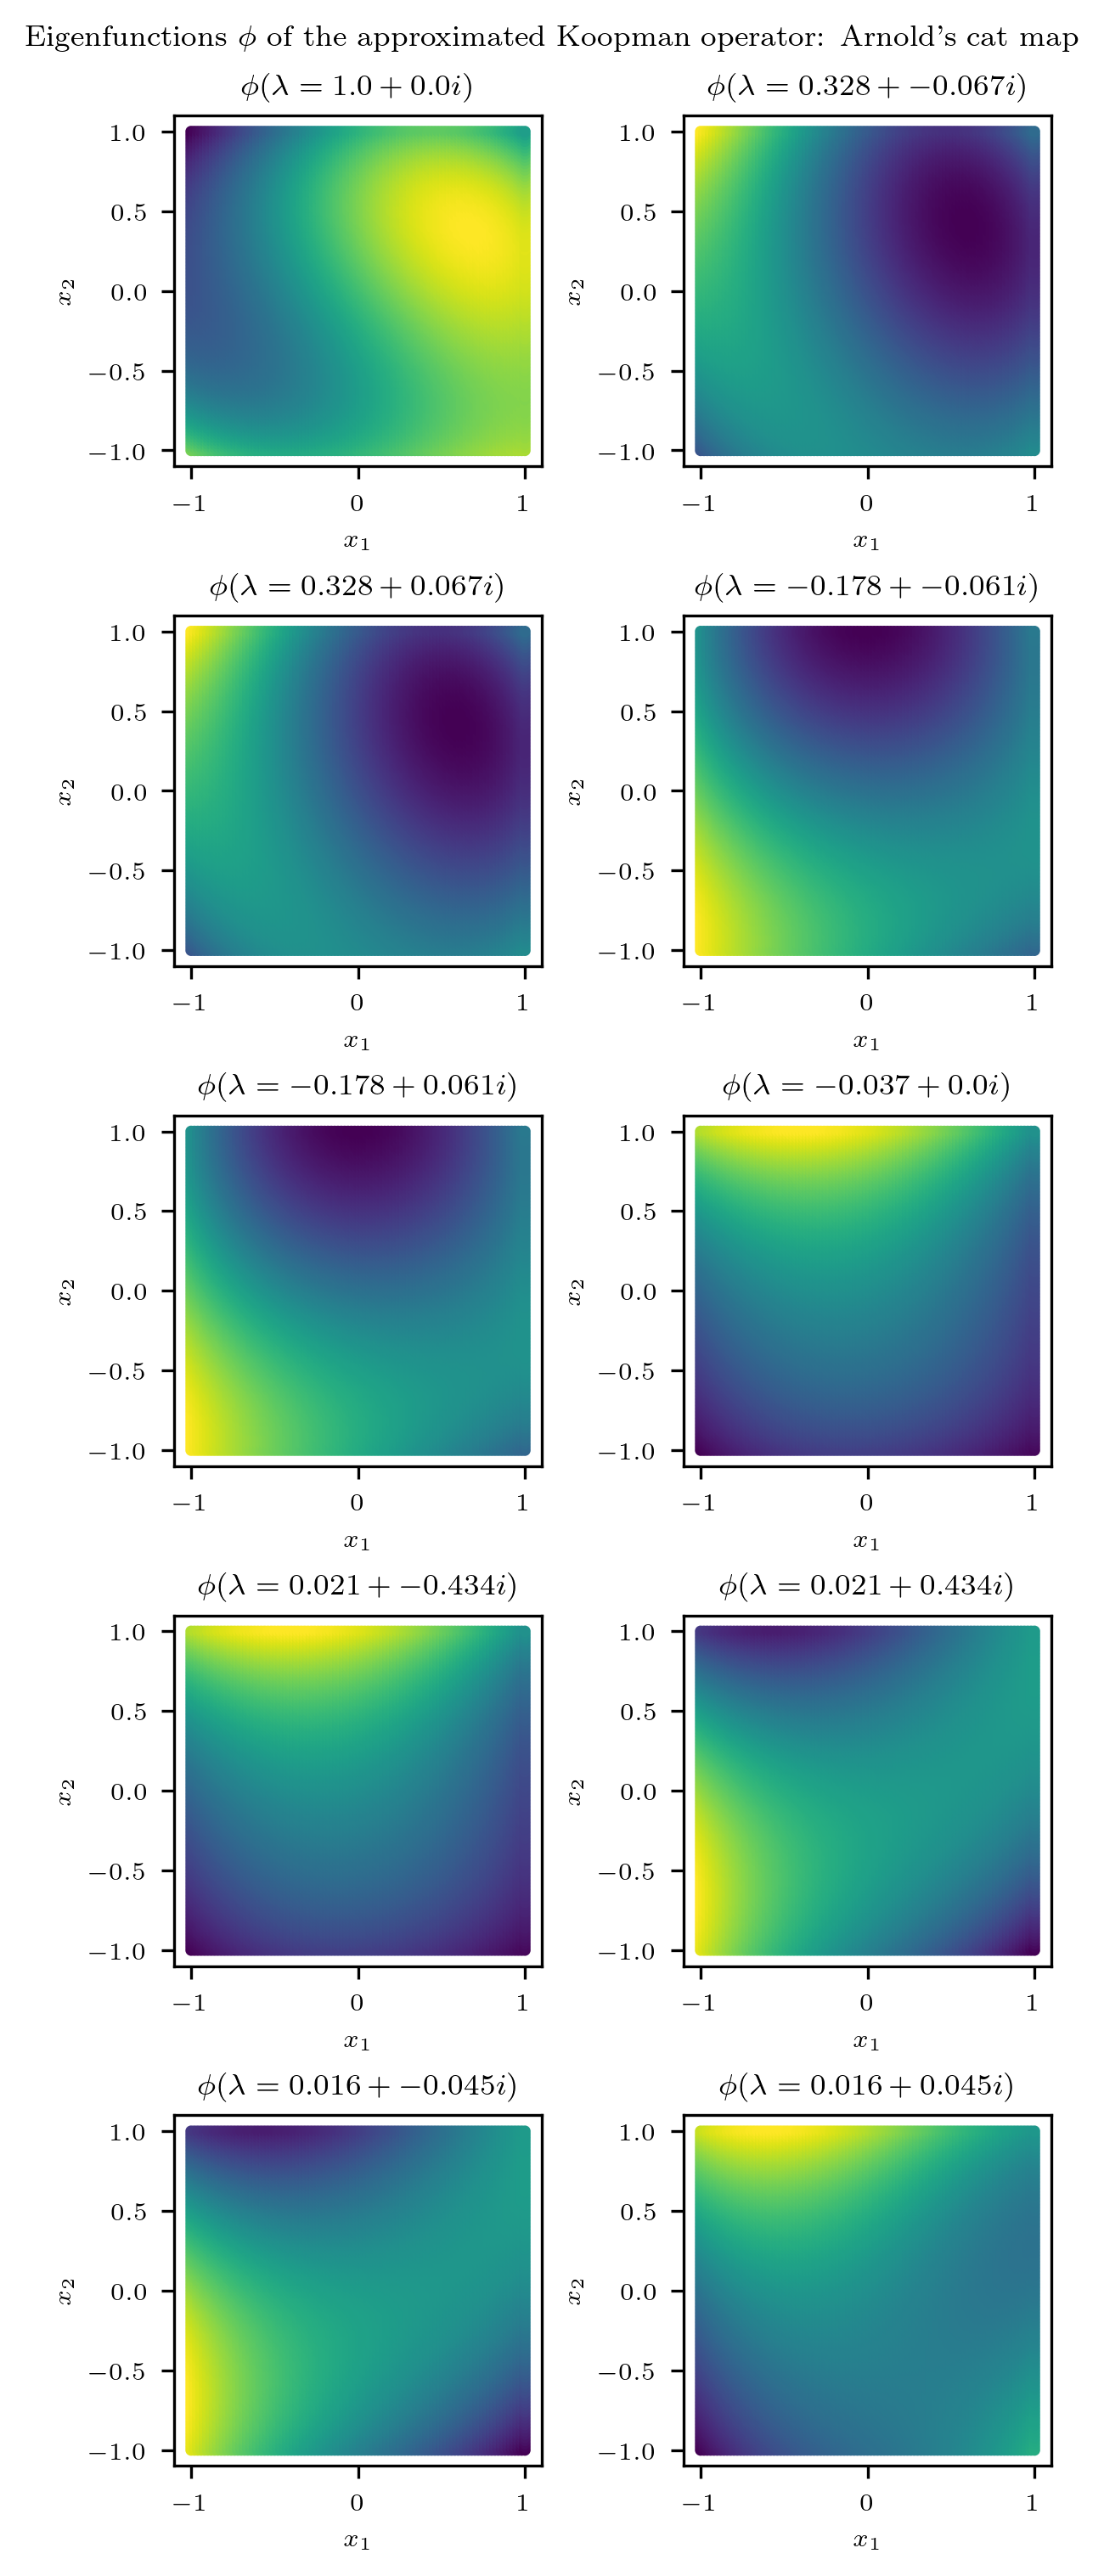

In [67]:
# Plot each eigenfunction phi, corresponding to each eigenvalue, evaluated on grid

fig, ax = plt.subplots(5, 2, figsize = (4, 10))
fig.suptitle(r"Eigenfunctions $\phi$ of the approximated Koopman operator: Arnold's cat map")
for i in range(5):
    for j in range(2):
        k = i * 2 + j
        ax[i][j].scatter(xgrid1.T.flatten(), xgrid2.T.flatten(), s = 5, c = vecnorm(phi[:, :, k]).T.flatten(), cmap = 'viridis')
        ax[i][j].set_title(rf'$\phi(\lambda = {np.around(np.real(eigenvals[k]), 3)} + {np.around(np.imag(eigenvals[k]), 3)}i)$')
        ax[i][j].set(xlabel=r'$x_1$', ylabel=r'$x_2$')

In [68]:
fig.savefig('approx_koopman_eigenfn.png', dpi=300)